## Imports

In [1]:
import pandas as pd
import glob
import datasets
import numpy as np

## Load Data

In [2]:
wiki_data = pd.read_csv("../../data/wikidata/wikidata-property-list.csv")
wiki_data = wiki_data[["Title", "ID", "Datatype", "Description"]]
wiki_data

,Title,ID,Datatype,Description
0,head of government,6,item,"head of the executive power of a town, city, m..."
1,brother,7,item,subject has the object as their brother
2,sister,9,item,subject has the object as their sister (female...
3,video,10,Commons file,relevant video
4,highway marker,14,Commons file,graphic representing the highway
...,...,...,...,...
1193,catholic.ru ID,1453,string,identifier on the site catholic.ru
1194,legal form,1454,item,legal form of an organization
1195,list of works,1455,item,link to the article with the works of a person
1196,list of monuments,1456,item,link to the list of heritage monuments in the ...


In [3]:
list(wiki_data[wiki_data["ID"] == 176]["Title"])[0]

'manufacturer'

In [4]:
code_to_lang_dict = {
    "bg": "Bulgarian",
    "ca": "Catalan",
    "cs": "Czech",
    "da": "Danish",
    "de": "German",
    "en": "English",
    "es": "Spanish",
    "fr": "French",
    "hr": "Croatian",
    "hu": "Hungarian",
    "it": "Italian",
    "nl": "Dutch",
    "pl": "Polish",
    "pt": "Portuguese",
    "ro": "Romanian",
    "ru": "Russian",
    "sl": "Slovenian",
    "sr": "Serbian",
    "sv": "Swedish",
    "uk": "Ukrainian",
}

In [5]:
lang_to_code_dict = {v: k for k, v in code_to_lang_dict.items()}

In [6]:
results_dict = {}
results_dict["language"] = []
results_dict["relation"] = []
results_dict["percentage change"] = []
results_dict["new ratio of rows"] = []
results_dict["old ratio of rows"] = []

hf_df = datasets.load_dataset("CalibraGPT/Fact-Completion")
file_names = glob.glob("../../data/result_logs/llama-30b/error-analysis/*.csv")

# confirm grabbing data correctly against LLaMa figure
# uncomment print statement at end of for loop to see
results_dfs = []
count = 0
for file in file_names:
    language = file.split(".csv")[0].split("-")[-1].capitalize()
    error_df = pd.read_csv(file)
    full_hf_df = hf_df[file.split(".csv")[0].split("-")[-1].capitalize()]
    full_hf_df = full_hf_df.to_pandas()
    print(
        f"for {language} we got {error_df.shape[0]} wrong out of {full_hf_df.shape[0]}"
    )
    # print(error_df.head())
    # print(full_hf_df.head())
    # stem is in both
    # dataset id is in both
    # to see if the model got something wrong, see if the dataset id in the full df is in the error
    error_ids = list(error_df["dataset_id"])
    correct = []
    counts = []
    relation_names = []
    for row in full_hf_df.iterrows():
        # track counts
        count += 1
        counts.append(count)
        # track errors
        correct.append(False) if row[1]["dataset_id"] in error_ids else correct.append(
            True
        )
        # track relation titles
        relation_id = int(row[1].relation[1:])
        relation_title = list(wiki_data[wiki_data["ID"] == relation_id]["Title"])[0]
        relation_names.append(relation_title)

    # append result to full df
    full_hf_df["correct"] = correct
    # append language to full df
    full_hf_df["language"] = [language] * full_hf_df.shape[0]
    # append language code to full df
    lang_code = lang_to_code_dict[language]
    full_hf_df["lang_code"] = [lang_code] * full_hf_df.shape[0]
    # append relation title to full df
    full_hf_df["relation_title"] = relation_names
    # also append an arbitrary id to have unique val for each row
    full_hf_df["analysis_id"] = counts

    results_dfs.append(full_hf_df)

results_df = pd.concat(results_dfs)
assert results_df.shape[0] == count

Found cached dataset parquet (/Users/tim/.cache/huggingface/datasets/CalibraGPT___parquet/CalibraGPT--Fact-Completion-24a24a1e4bf6e4a8/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/20 [00:00<?, ?it/s]

for Serbian we got 2170 wrong out of 5426
for Ukrainian we got 2138 wrong out of 7918
for Dutch we got 3309 wrong out of 22590
for Swedish we got 3440 wrong out of 21576
for Hungarian we got 1128 wrong out of 4650
for Catalan we got 3021 wrong out of 18898
for Polish we got 2137 wrong out of 9484
for Russian we got 996 wrong out of 3289
for Bulgarian we got 5658 wrong out of 20577
for Slovenian we got 1890 wrong out of 7873
for English we got 2782 wrong out of 26254
for German we got 2323 wrong out of 16287
for Portuguese we got 3719 wrong out of 22974
for Czech we got 2080 wrong out of 9427
for Spanish we got 3430 wrong out of 18786
for Croatian we got 1715 wrong out of 7358
for Danish we got 4255 wrong out of 23365
for French we got 2910 wrong out of 18395
for Italian we got 3192 wrong out of 20448
for Romanian we got 3035 wrong out of 17568


## Explore Data

In [7]:
results_df.head()

,dataset_id,stem,true,false,relation,subject,object,correct,language,lang_code,relation_title,analysis_id
0,calinet_8922,Приус производи,Тоиота,Хонда,P176,Приус,Тоиота,True,Serbian,sr,manufacturer,1
1,rome_5025,Сундар Пицхаи ради за,Гоогле,Аппле,P108,Сундар Пицхаи,Гоогле,False,Serbian,sr,employer,2
2,rome_21333,"Главни град Народне Републике Кине,",Пекинг,Кабул,P36,Народна Република Кина,Пекинг,True,Serbian,sr,capital,3
3,rome_8738,У Синт Мартену разумеју,холандски,дански,P37,Синт Маартен,холандски,True,Serbian,sr,official language,4
4,rome_8783,Хаас Хоусе се налази у месту,Беч,Алберта,P131,Хаас Хоусе,Беч,True,Serbian,sr,is in the administrative territorial entity,5


In [8]:
# average number of times a dataset_id gets shared across langs?
# 11.5
np.mean(results_df["dataset_id"].value_counts())

11.546545288337015

<Axes: >

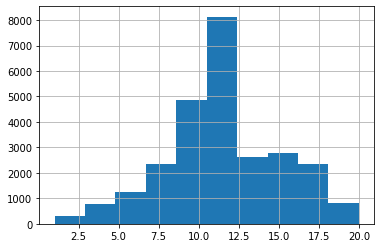

In [9]:
# hist of our usage
results_df["dataset_id"].value_counts().hist()

In [10]:
# how many dataset_id's get used across all 20 langs?
np.count_nonzero(results_df["dataset_id"].value_counts().values == 20)

214

In [11]:
# how many dataset_id's get used across only 1 lang?
np.count_nonzero(results_df["dataset_id"].value_counts().values == 1)

77

In [12]:
results_df[results_df["language"] == "English"]["correct"].value_counts()

True     23472
False     2782
Name: correct, dtype: int64

In [83]:
# our prius fact appears in 15 cuts 
# if you don't take into account translations
results_df[results_df["subject"] == "Prius"].shape[0]

15

In [84]:
# look at all the versions of our prius fact, which appears in 16 cuts
# when you take into account that its translated in serbian
results_df[results_df["dataset_id"] == "calinet_8922"].shape[0]

16

In [15]:
# most frequent entities + relation title pairs
results_df[["subject", "relation_title"]].value_counts()[:20]

subject              relation_title       
Mac OS               developer                73
They                 record label             71
Vincent van Gogh     work location            66
iOS                  developer                51
Tizen                developer                50
Arcapita             located in               49
SNES-CD              manufacturer             49
Sichuan              shares border with       47
Tree Hill            original network         46
Daniel               language                 45
Berry Gordy          record label             45
PAX                  located in               42
Couto Misto          official language        41
Sri Lanka            official language        40
Max Weber            field of work            39
Heilmann & Littmann  headquarters location    39
Feynman              field of work            39
Tycho Brahe          work location            39
Prison Break         original network         38
Illinois             share

In [74]:
# mapping between dataset id and the english form of a subject
dataset_id_to_eng_subject = {}
for row in results_df.iterrows():
    if row[1].language == 'English':
        if row[1].dataset_id not in dataset_id_to_eng_subject:
            dataset_id_to_eng_subject[row[1].dataset_id] = row[1].subject

In [73]:
# put in an id and get the english subject back
dataset_id_to_eng_subject['rome_21844']

'Megan Rapinoe'

In [111]:
entities = {}
for row in results_df.iterrows():
    # gather helpful row level data
    # the subject
    subject = row[1].subject
    # whether the model got it right
    val = row[1].correct
    # the dataset id
    dataset_id = row[1].dataset_id
    # the english version of the subject
    english_subject = dataset_id_to_eng_subject[dataset_id]

    # commit it to our tracking dict
    if english_subject not in entities:
        entities[english_subject] = {"correct": 0, "incorrect": 0, "langs": {}, "alternate_forms": {}, "dataset_ids": set()}
    
    # counter of correct/incorrect for that subject
    if val:
        entities[english_subject]["correct"] += 1
    else:
        entities[english_subject]["incorrect"] += 1
     
    # track language
    lang = row[1].lang_code
    
    if lang not in entities[english_subject]["langs"]:
        entities[english_subject]["langs"][lang] = 1

    else:
        entities[english_subject]["langs"][lang] += 1
    
    # track any alternate forms
    entities[english_subject]["alternate_forms"][lang] = subject
    
    entities[english_subject]["dataset_ids"].add(dataset_id)

In [117]:
entity_names = []
correct = []
incorrect = []
total = []
pct = []
langs = []
num_langs = []
alternate_forms = []
dataset_ids = []
for k, v in entities.items():
    entity_names.append(k)
    # track # of times entity is used in a correct statement, incorrect, and pct accuracy
    correct.append(v["correct"])
    incorrect.append(v["incorrect"])
    total.append(int(v["correct"]) + int(v["incorrect"]))
    pct.append(int(v["correct"]) / (int(v["correct"]) + int(v["incorrect"])))
    # track # of languages the entity is used in
    langs.append(v["langs"])
    num_langs.append(len(v["langs"]))
    alternate_forms.append(v["alternate_forms"])
    # track dataset ids its used in
    dataset_ids.append(list(v["dataset_ids"]))
    # sanity check
    assert((int(v["correct"]) + int(v["incorrect"]) == sum(v["langs"].values())))

In [118]:
# the average entity appears in ~12 langs
# slightly higher than the average number
# for ids across langs
# implying that *most* entities only get used in one datset id
# while a small proportion get reused
# could track this by comparing
# the number of times an entity appears in its total_usages
np.mean(num_langs)

11.867738745323988

In [119]:
entity_analysis_df = pd.DataFrame(
    {
        "entity": entity_names,
        "num_correct": correct,
        "num_incorrect": incorrect,
        "total_usages": total,
        "percent_accuracy": pct,
        "languages": langs,
        "num_languages": num_langs,
        "alternate_forms": alternate_forms,
        "dataset_ids": dataset_ids
    }
)

In [120]:
entity_analysis_df.head(20)

,entity,num_correct,num_incorrect,total_usages,percent_accuracy,languages,num_languages,alternate_forms,dataset_ids
0,Prius,16,0,16,1.000000,"{'sr': 1, 'uk': 1, 'nl': 1, 'sv': 1, 'ca': 1, ...",16,"{'sr': 'Приус', 'uk': 'Prius', 'nl': 'Prius', ...",[calinet_8922]
1,Sundar Pichai,18,1,19,0.947368,"{'sr': 1, 'uk': 1, 'nl': 1, 'sv': 1, 'ca': 1, ...",19,"{'sr': 'Сундар Пицхаи', 'uk': 'Сундар Пічаї', ...",[rome_5025]
2,People's Republic of China,17,0,17,1.000000,"{'sr': 1, 'uk': 1, 'nl': 1, 'sv': 1, 'hu': 1, ...",17,"{'sr': 'Народна Република Кина', 'uk': 'Народн...",[rome_21333]
3,Sint Maarten,11,10,21,0.523810,"{'sr': 1, 'nl': 2, 'sv': 1, 'ca': 1, 'pl': 1, ...",14,"{'sr': 'Синт Маартен', 'nl': 'Sint Maarten', '...","[rome_8738, rome_20596]"
4,Haas House,9,5,14,0.642857,"{'sr': 1, 'nl': 1, 'sv': 1, 'hu': 1, 'ca': 1, ...",14,"{'sr': 'Хаас Хоусе', 'nl': 'Haas House', 'sv':...",[rome_8783]
5,Iran,98,6,104,0.942308,"{'sr': 3, 'uk': 2, 'nl': 8, 'sv': 8, 'hu': 3, ...",20,"{'sr': 'Иран', 'uk': 'Іран', 'nl': 'Iran', 'sv...","[calinet_3044, calinet_482, calinet_231, calin..."
6,Bavaria,48,11,59,0.813559,"{'sr': 1, 'uk': 1, 'nl': 5, 'sv': 5, 'hu': 1, ...",19,"{'sr': 'Бавариа', 'uk': 'Баварія', 'nl': 'Bava...","[calinet_2942, rome_4438, calinet_2742, caline..."
7,Lil Wayne,15,3,18,0.833333,"{'sr': 1, 'uk': 1, 'nl': 1, 'sv': 1, 'hu': 1, ...",18,"{'sr': 'Лил Ваине', 'uk': 'Lil Wayne', 'nl': '...",[calinet_12590]
8,Fortran,18,0,18,1.000000,"{'sr': 1, 'uk': 1, 'nl': 1, 'sv': 1, 'ca': 1, ...",18,"{'sr': 'Фортран', 'uk': 'Fortran', 'nl': 'Fort...",[rome_18369]
9,Paramore,13,10,23,0.565217,"{'sr': 1, 'uk': 1, 'nl': 2, 'sv': 1, 'hu': 1, ...",19,"{'sr': 'Параморе', 'uk': 'Paramore', 'nl': 'Pa...","[calinet_8171, calinet_3670]"


## Most Correct and Incorrect by Raw Count

In [122]:
# the top 20 most incorrect (by raw count)
entity_analysis_df.sort_values(by="num_incorrect", ascending=False)[:20]

,entity,num_correct,num_incorrect,total_usages,percent_accuracy,languages,num_languages,alternate_forms,dataset_ids
344,They,174,315,489,0.355828,"{'sr': 18, 'uk': 22, 'nl': 27, 'sv': 31, 'hu':...",20,"{'sr': 'Они', 'uk': 'Вони', 'nl': 'They', 'sv'...","[calinet_12932, calinet_12566, calinet_2272, c..."
1072,European Union,74,68,142,0.521127,"{'sr': 7, 'uk': 3, 'nl': 10, 'sv': 7, 'hu': 5,...",20,"{'sr': 'Европска унија', 'uk': 'Європейський С...","[rome_10474, rome_6214, rome_15290, rome_21264..."
1454,Tree Hill,6,42,48,0.125000,"{'sr': 2, 'uk': 3, 'nl': 1, 'sv': 3, 'ca': 3, ...",19,"{'sr': 'Трее Хилл', 'uk': 'Tree Hill', 'nl': '...","[calinet_4819, calinet_4962, calinet_4804]"
3509,Doctor Who,50,41,91,0.549451,"{'sr': 1, 'uk': 2, 'nl': 6, 'sv': 5, 'hu': 2, ...",20,"{'sr': 'Лекар који', 'uk': 'Лікар, який', 'nl'...","[calinet_7590, calinet_8076, calinet_4572, rom..."
4960,Cam-Pact,4,33,37,0.108108,"{'sr': 1, 'uk': 2, 'nl': 2, 'sv': 2, 'hu': 2, ...",20,"{'sr': 'Цам-Пацт', 'uk': 'Cam-Pact', 'nl': 'Ca...","[rome_14029, calinet_12903]"
684,VAX,4,32,36,0.111111,"{'sr': 2, 'uk': 2, 'nl': 2, 'sv': 2, 'ca': 2, ...",19,"{'sr': 'ВАКС', 'uk': 'VAX', 'nl': 'VAX', 'sv':...","[calinet_8905, calinet_8606]"
2389,ice cream cone,50,32,82,0.609756,"{'sr': 3, 'uk': 3, 'nl': 6, 'sv': 6, 'hu': 3, ...",19,"{'sr': 'корнет за сладолед', 'uk': 'ріжок моро...","[rome_18400, rome_12775, rome_16755, rome_872,..."
1252,China,101,32,133,0.759398,"{'sr': 2, 'uk': 2, 'nl': 10, 'sv': 11, 'hu': 2...",20,"{'sr': 'Кина', 'uk': 'Китай', 'nl': 'China', '...","[calinet_2641, calinet_2782, calinet_459, cali..."
5570,Sushi Pack,1,31,32,0.031250,"{'uk': 2, 'nl': 2, 'sv': 2, 'ca': 2, 'pl': 2, ...",17,"{'uk': 'Sushi Pack', 'nl': 'Sushi Pack', 'sv':...","[rome_8450, calinet_4657]"
1378,Life Unexpected,3,30,33,0.090909,"{'sr': 2, 'uk': 1, 'nl': 2, 'sv': 2, 'ca': 2, ...",19,"{'sr': 'Лифе Унекпецтед', 'uk': 'Life Unexpect...","[calinet_4836, calinet_4598]"


In [123]:
# the top 20 most correct (by raw count)
entity_analysis_df.sort_values(by="num_correct", ascending=False)[:20]

,entity,num_correct,num_incorrect,total_usages,percent_accuracy,languages,num_languages,alternate_forms,dataset_ids
344,They,174,315,489,0.355828,"{'sr': 18, 'uk': 22, 'nl': 27, 'sv': 31, 'hu':...",20,"{'sr': 'Они', 'uk': 'Вони', 'nl': 'They', 'sv'...","[calinet_12932, calinet_12566, calinet_2272, c..."
1162,Russia,157,24,181,0.867403,"{'sr': 4, 'uk': 3, 'nl': 13, 'sv': 11, 'hu': 4...",20,"{'sr': 'Русија', 'uk': 'Росія', 'nl': 'Rusland...","[calinet_3479, calinet_2526, calinet_2584, cal..."
2825,South Africa,116,2,118,0.983051,"{'sr': 2, 'uk': 2, 'nl': 11, 'sv': 8, 'hu': 2,...",20,"{'sr': 'Јужна Африка', 'uk': 'Південна Африка'...","[rome_10612, calinet_3031, calinet_66, calinet..."
4364,Germany,113,19,132,0.856061,"{'sr': 1, 'uk': 2, 'nl': 12, 'sv': 10, 'hu': 2...",20,"{'sr': 'Немачка', 'uk': 'Німеччина', 'nl': 'Du...","[calinet_2502, calinet_478, calinet_364, calin..."
2494,Hungary,103,13,116,0.887931,"{'sr': 1, 'nl': 12, 'sv': 8, 'hu': 1, 'ca': 7,...",18,"{'sr': 'Мађарска', 'nl': 'Hongarije', 'sv': 'U...","[calinet_142, rome_17071, calinet_2879, caline..."
1140,India,102,8,110,0.927273,"{'sr': 2, 'uk': 4, 'nl': 9, 'sv': 5, 'hu': 3, ...",20,"{'sr': 'Индија', 'uk': 'Індія', 'nl': 'India',...","[calinet_2501, calinet_60, calinet_2634, calin..."
1252,China,101,32,133,0.759398,"{'sr': 2, 'uk': 2, 'nl': 10, 'sv': 11, 'hu': 2...",20,"{'sr': 'Кина', 'uk': 'Китай', 'nl': 'China', '...","[calinet_2641, calinet_2782, calinet_459, cali..."
845,France,98,3,101,0.970297,"{'sr': 2, 'uk': 2, 'nl': 8, 'sv': 8, 'hu': 2, ...",20,"{'sr': 'Француска', 'uk': 'Франція', 'nl': 'Fr...","[rome_17806, calinet_2519, calinet_257, caline..."
5,Iran,98,6,104,0.942308,"{'sr': 3, 'uk': 2, 'nl': 8, 'sv': 8, 'hu': 3, ...",20,"{'sr': 'Иран', 'uk': 'Іран', 'nl': 'Iran', 'sv...","[calinet_3044, calinet_482, calinet_231, calin..."
1203,Belgium,97,4,101,0.960396,"{'sr': 3, 'uk': 2, 'nl': 9, 'sv': 7, 'hu': 2, ...",20,"{'sr': 'Белгија', 'uk': 'Бельгія', 'nl': 'Belg...","[rome_18642, calinet_3034, rome_19222, rome_11..."


## Most Correct and Incorrect by Percent (at least 10 usages)

In [103]:
# there are 6496 entities that were used more than 10 times and always correct!

len(
    entity_analysis_df[
        (entity_analysis_df["total_usages"] >= 10)
        & (entity_analysis_df["percent_accuracy"] == 1.0)
    ]
)

6496

<Axes: >

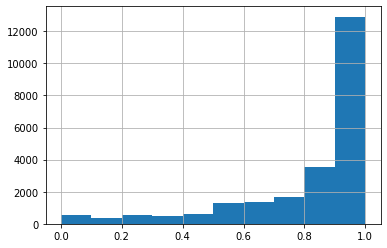

In [109]:
entity_analysis_df["percent_accuracy"].hist()

In [104]:
# and they comprise 88k of our corrects.
sum(
    entity_analysis_df[
        (entity_analysis_df["total_usages"] >= 10)
        & (entity_analysis_df["percent_accuracy"] == 1.0)
    ]["total_usages"]
)

88138

In [105]:
# meanwhile, there were just 238 entities that were consistently bad
len(
    entity_analysis_df[
        (entity_analysis_df["total_usages"] >= 10)
        & (entity_analysis_df["percent_accuracy"] == 0.0)
    ]
)

238

In [106]:
# and they comprise just 3405 of our incorrect
sum(
    entity_analysis_df[
        (entity_analysis_df["total_usages"] >= 10)
        & (entity_analysis_df["percent_accuracy"] == 0.0)
    ]["total_usages"]
)

3405

In [146]:
# meanwhile, there were just 238 entities that were consistently bad
entity_analysis_df[
    (entity_analysis_df["total_usages"] >= 10)
    & (entity_analysis_df["percent_accuracy"] == 0.0)
][:50]

,entity,num_correct,num_incorrect,total_usages,percent_accuracy,languages,num_languages,alternate_forms,dataset_ids
49,Visible World,0,19,19,0.0,"{'sr': 1, 'uk': 1, 'nl': 1, 'sv': 1, 'ca': 1, ...",19,"{'sr': 'Видљиви свет', 'uk': 'Видимий світ', '...",[calinet_12615]
79,John McEntee,0,19,19,0.0,"{'sr': 1, 'uk': 1, 'nl': 1, 'sv': 1, 'ca': 1, ...",19,"{'sr': 'Јохн МцЕнтее', 'uk': 'John McEntee', '...",[calinet_12605]
212,Tom Leopold,0,15,15,0.0,"{'sr': 1, 'nl': 1, 'sv': 1, 'ca': 1, 'pl': 1, ...",15,"{'sr': 'Том Леополд', 'nl': 'Tom Leopold', 'sv...",[rome_19964]
221,Barry Pilton,0,15,15,0.0,"{'sr': 1, 'nl': 1, 'sv': 1, 'ca': 1, 'pl': 1, ...",15,"{'sr': 'Барри Пилтон', 'nl': 'Barry Pilton', '...",[calinet_5398]
335,Music & Me,0,19,19,0.0,"{'sr': 1, 'uk': 1, 'nl': 1, 'sv': 1, 'ca': 1, ...",19,"{'sr': 'Музика и ја', 'uk': 'Music & Me', 'nl'...",[calinet_12518]
398,Inside Edition,0,19,19,0.0,"{'sr': 1, 'uk': 1, 'nl': 1, 'sv': 1, 'ca': 1, ...",19,"{'sr': 'Инсиде Едитион', 'uk': 'Inside Edition...",[calinet_4909]
563,Brave Belt,0,20,20,0.0,"{'sr': 1, 'uk': 1, 'nl': 1, 'sv': 1, 'hu': 1, ...",20,"{'sr': 'Браве Белт', 'uk': 'Brave Belt', 'nl':...",[calinet_12575]
597,Nina Hagen Band,0,17,17,0.0,"{'sr': 1, 'uk': 1, 'nl': 1, 'sv': 1, 'ca': 1, ...",17,"{'sr': 'Нина Хаген Банд', 'uk': 'Nina Hagen Ba...",[calinet_12679]
642,Con Funk Shun,0,20,20,0.0,"{'sr': 1, 'uk': 1, 'nl': 1, 'sv': 1, 'hu': 1, ...",20,"{'sr': 'Цон Функ Схун', 'uk': 'Con Funk Shun',...",[calinet_8412]
772,Nao Takasugi,0,13,13,0.0,"{'sr': 1, 'uk': 1, 'nl': 1, 'sv': 1, 'hu': 1, ...",13,"{'sr': 'Nao Takasugi', 'uk': 'Nao Takasugi', '...",[rome_20671]


## Analyzing a Single Entity

In [250]:
def get_lang_usage_report_for_entity(entity_val):
    usage_dict = entity_analysis_df[entity_analysis_df['entity'] == entity_val]['languages'].values[0]
        
    usage_dict = {code_to_lang_dict[k]: {'correct': 0, 'incorrect': 0} for k, v in usage_dict.items()}
    # ok, how many of those usages are correct vs not?
    dataset_ids = list(entity_analysis_df[entity_analysis_df['entity'] == entity_val]['dataset_ids'])[0]
    
    for dataset_id in dataset_ids:
        subset = results_df[results_df['dataset_id'] == dataset_id]
        for row in subset.iterrows():
            lang_used = row[1].language
            correct = row[1].correct
            
            if correct:
                usage_dict[lang_used]['correct'] += 1
            else:
                usage_dict[lang_used]['incorrect'] += 1
                                
    return usage_dict

In [251]:
get_lang_usage_report_for_entity('Kerala')

{'Serbian': {'correct': 1, 'incorrect': 0},
 'Ukrainian': {'correct': 3, 'incorrect': 0},
 'Dutch': {'correct': 5, 'incorrect': 1},
 'Swedish': {'correct': 4, 'incorrect': 0},
 'Catalan': {'correct': 5, 'incorrect': 1},
 'Polish': {'correct': 3, 'incorrect': 0},
 'Bulgarian': {'correct': 5, 'incorrect': 0},
 'Slovenian': {'correct': 2, 'incorrect': 0},
 'English': {'correct': 6, 'incorrect': 0},
 'German': {'correct': 6, 'incorrect': 0},
 'Portuguese': {'correct': 6, 'incorrect': 0},
 'Czech': {'correct': 3, 'incorrect': 0},
 'Spanish': {'correct': 3, 'incorrect': 1},
 'Croatian': {'correct': 1, 'incorrect': 0},
 'Danish': {'correct': 6, 'incorrect': 0},
 'French': {'correct': 5, 'incorrect': 0},
 'Italian': {'correct': 5, 'incorrect': 0},
 'Romanian': {'correct': 5, 'incorrect': 0}}

In [142]:
def get_rows_by_entity(entity_val, outcome = False):
    ids = list(entity_analysis_df[entity_analysis_df['entity'] == entity_val]['dataset_ids'])[0]
    return results_df[(results_df['dataset_id'].isin(ids)) & (results_df['correct'] == outcome)]

In [143]:
get_rows_by_entity('Kerala')

,dataset_id,stem,true,false,relation,subject,object,correct,language,lang_code,relation_title,analysis_id
11211,rome_16815,In Kerala verstaan ​​ze <br> In Kerala begrijp...,Engels,Fins,P37,Kerala,Engels,False,Dutch,nl,official language,24556
9395,rome_16815,"A Kerala, entenen <br> A Kerala, entenen el",Anglès,finès,P37,Kerala,Anglès,False,Catalan,ca,official language,71556
9320,rome_16815,En Kerala entienden,Inglés,finlandés,P37,Kerala,Inglés,False,Spanish,es,official language,206544
